# <font color="#dd0000">**REALLY IMPORTANT !!!**</font><br /> 
1. The following code is written and tested in the **Colab Pro** enviorment. Where the rumtime has a P100 GPU and high-ram.

2. Since we have build many models, you will have **CUDA out of RAM** issue if you run more than 1 model's code in each rumtime, then the solution is restart the runtime (colab), or the kernel (jupyternotebook). Then all the **variables in the RAM** will be **lost**, but the file in the disk and the output of cells will still be there. After the reatsrt, run the **Processing the data** section and the code you want.

3. Run the following code with a GPU whose RAM is larger or equal to 16280MiB, otherwise the python will crash, the resart method doesn't work for this situation. 

4. Put the image zip file in: /content/drive/MyDrive/5329/multi-label-classification-competition-22.zip

In [31]:
!python --version

Python 3.7.13


In [21]:
# check GPU
!nvidia-smi

Wed May 18 06:15:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |   8077MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Processing the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/5329/multi-label-classification-competition-22.zip /content
!unzip /content/multi-label-classification-competition-22.zip

Streaming output truncated to the last 5000 lines.
  inflating: COMP5329S1A2Dataset/data/550.jpg  
  inflating: COMP5329S1A2Dataset/data/5500.jpg  
  inflating: COMP5329S1A2Dataset/data/5501.jpg  
  inflating: COMP5329S1A2Dataset/data/5502.jpg  
  inflating: COMP5329S1A2Dataset/data/5503.jpg  
  inflating: COMP5329S1A2Dataset/data/5504.jpg  
  inflating: COMP5329S1A2Dataset/data/5505.jpg  
  inflating: COMP5329S1A2Dataset/data/5506.jpg  
  inflating: COMP5329S1A2Dataset/data/5507.jpg  
  inflating: COMP5329S1A2Dataset/data/5508.jpg  
  inflating: COMP5329S1A2Dataset/data/5509.jpg  
  inflating: COMP5329S1A2Dataset/data/551.jpg  
  inflating: COMP5329S1A2Dataset/data/5510.jpg  
  inflating: COMP5329S1A2Dataset/data/5511.jpg  
  inflating: COMP5329S1A2Dataset/data/5512.jpg  
  inflating: COMP5329S1A2Dataset/data/5513.jpg  
  inflating: COMP5329S1A2Dataset/data/5514.jpg  
  inflating: COMP5329S1A2Dataset/data/5515.jpg  
  inflating: COMP5329S1A2Dataset/data/5516.jpg  
  inflating: COMP532

In [4]:
!pip install timm

     |████████████████████████████████| 431 kB 7.2 MB/s 


In [6]:
!pip install -U fastai

     |████████████████████████████████| 197 kB 7.9 MB/s 
     |████████████████████████████████| 59 kB 8.3 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [7]:
# from fastai.data.all import *
import timm
from fastai.vision.all import *

import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

In [8]:
import re
import pandas as pd
from io import StringIO
os.chdir('file_dir')
#!pwd
path = os.getcwd()
FILENAME = 'train.csv'
with open(FILENAME) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
train_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

FILENAME = 'test.csv'
with open(FILENAME) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


In [9]:
train_image_path = 'file_dir'
if not os.path.exists(train_image_path):
    os.mkdir(train_image_path)
test_image_path = 'file_dir'
if not os.path.exists(test_image_path):
    os.mkdir(test_image_path)

In [10]:
# move the train image to the train folder
for i in range((train_df.shape[0])):
  if not os.path.exists('file_dir'+train_df['ImageID'][i]):
    os.system('cp /file_dir'+train_df['ImageID'][i]+' file_dir')

In [11]:
# move the test image to the test folder
for i in range((test_df.shape[0])):
  if not os.path.exists('file_dir'+test_df['ImageID'][i]):
    os.system('cp /file_dir'+test_df['ImageID'][i]+' file_dir)

In [12]:
# define the f1 score
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_micro.name = 'F1(mean)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'

In [15]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('file_dir')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=1),  # resize the images, there we can also do other images transforms
                   batch_tfms=aug_transforms(pad_mode='zeros'))  # like stretch the images, padding, and many other data augmentations

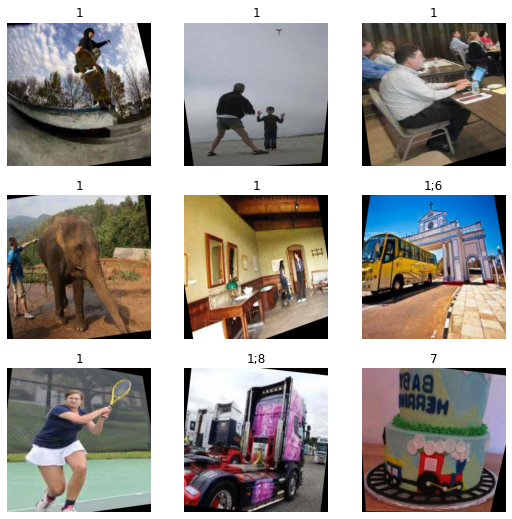

In [16]:
# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

# preview of images
dls = images.dataloaders(train_df,bs=24) # batch size is 24
dls.show_batch()

# Experiments and results

## Model Selection

### 1) Resnet50

In [ ]:
# define the model/learner here
learner = vision_learner(dls, resnet50, loss_func= loss_function, metrics= f1_micro)

SuggestedLRs(valley=0.001737800776027143)

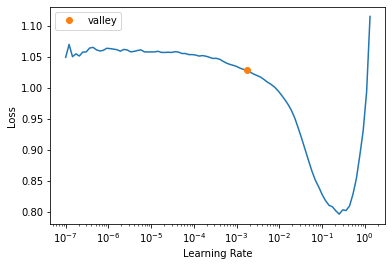

In [ ]:
# This function will give a suggested lr
learner.lr_find()

In [ ]:
learner.fine_tune(5, base_lr=0.001, freeze_epochs=5)

epoch,train_loss,valid_loss,f1_score,time
0,0.849610,0.641217,0.281198,03:59
1,0.380155,0.201236,0.733209,03:58
2,0.135194,0.110272,0.756010,03:58
3,0.114134,0.098701,0.784230,03:58
4,0.104505,0.094255,0.792671,03:58


epoch,train_loss,valid_loss,f1_score,time
0,0.093795,0.087385,0.809457,05:00
1,0.088283,0.084861,0.818018,04:57
2,0.077269,0.081759,0.823482,04:57
3,0.063461,0.081179,0.829076,04:58
4,0.059694,0.081599,0.826913,04:57


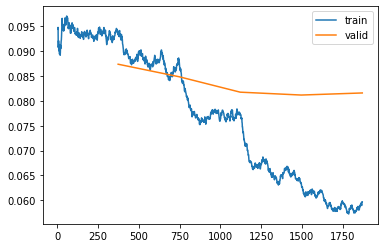

In [ ]:
learner.recorder.plot_loss()

Here we can see the loss of validation set is steady in the last 3 epochs, which means 10 epochs of training is enough for now, considering the time consumption. So we use 10 epochs as a standard for the following model comparision 

### 2) resnext50_32x4d

In [ ]:
from torchvision.models import resnext50_32x4d
learner_resnext50_32x4d = vision_learner(dls, resnext50_32x4d, loss_func= loss_function, metrics= [f1_micro,f1_samples])

SuggestedLRs(valley=0.0020892962347716093)

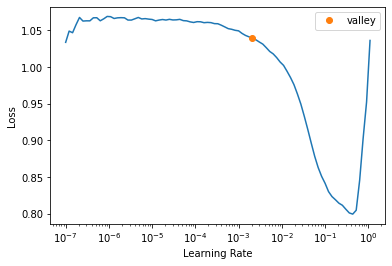

In [ ]:
learner_resnext50_32x4d.lr_find()

In [ ]:
learner_resnext50_32x4d.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.739017,0.510676,0.373843,0.396049,05:45
1,0.164831,0.113696,0.750460,0.767917,05:42
2,0.114001,0.098920,0.789692,0.813836,05:41
3,0.101014,0.093272,0.798834,0.827664,05:41
4,0.094099,0.088356,0.807309,0.830179,05:41


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.084885,0.084904,0.815617,0.839237,07:21
1,0.081549,0.083800,0.821382,0.846408,07:19
2,0.071861,0.082798,0.825961,0.851038,07:19
3,0.068975,0.081569,0.830764,0.852364,07:19
4,0.064558,0.081723,0.831006,0.854925,07:19


SuggestedLRs(valley=3.0199516913853586e-05)

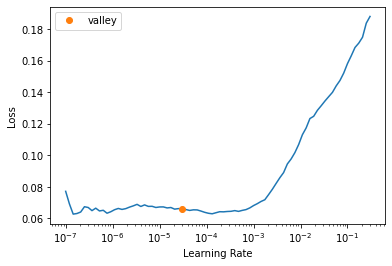

In [ ]:
learner_resnext50_32x4d.lr_find()

### 3) regnet_y_3_2gf

In [ ]:
from torchvision.models import regnet_y_3_2gf
learner_regnet_y_3_2gf = vision_learner(dls, regnet_y_3_2gf, loss_func= loss_function, metrics= [f1_micro,f1_samples])

SuggestedLRs(valley=0.002511886414140463)

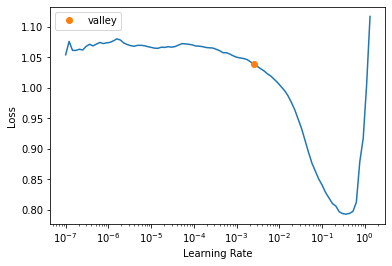

In [ ]:
learner_regnet_y_3_2gf.lr_find()

In [ ]:
learner_regnet_y_3_2gf.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.751114,0.545462,0.343183,0.359211,04:48
1,0.174746,0.120215,0.725132,0.738727,04:47
2,0.119674,0.101516,0.774283,0.798250,04:47
3,0.108423,0.093228,0.790871,0.814623,04:47
4,0.097736,0.089663,0.802356,0.827090,04:47


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.087872,0.085021,0.813449,0.835734,06:23
1,0.085326,0.083168,0.815900,0.838461,06:21
2,0.079431,0.081503,0.821527,0.845513,06:21
3,0.076128,0.080284,0.828542,0.851104,06:21
4,0.071836,0.080104,0.826915,0.849366,06:21


### 4) regnet_x_3_2gf

In [ ]:
from torchvision.models import regnet_x_3_2gf
learner_regnet_x_3_2gf = vision_learner(dls, regnet_x_3_2gf, loss_func= loss_function, metrics= f1_micro)

Downloading: "https://download.pytorch.org/models/regnet_x_3_2gf-f342aeae.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_3_2gf-f342aeae.pth


  0%|          | 0.00/58.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.002511886414140463)

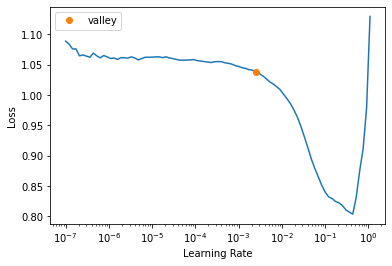

In [ ]:
learner_regnet_x_3_2gf.lr_find()

In [ ]:
learner_regnet_x_3_2gf.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,f1_score,time
0,0.759217,0.549219,0.321286,04:06
1,0.172248,0.118223,0.742030,04:03
2,0.123338,0.103011,0.774494,04:03
3,0.106851,0.094229,0.796082,04:03
4,0.100120,0.088956,0.806700,04:04


epoch,train_loss,valid_loss,f1_score,time
0,0.088628,0.086104,0.810615,05:23
1,0.084502,0.084502,0.816743,05:21
2,0.081079,0.082847,0.821796,05:21
3,0.076325,0.081969,0.823701,05:21
4,0.075695,0.082004,0.823918,05:21


### 4) regnetz_d8

In [ ]:
learner_regnetz_d8 = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])

SuggestedLRs(valley=0.005248074419796467)

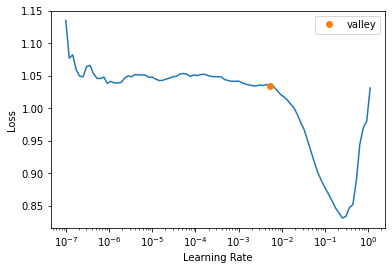

In [ ]:
learner_regnetz_d8.lr_find()

In [ ]:
learner_regnetz_d8.fine_tune(5, base_lr=0.005, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.149810,0.120972,0.734226,0.754531,10:47
1,0.124579,0.109942,0.754770,0.769895,10:45
2,0.123089,0.104239,0.770723,0.796776,10:44
3,0.107672,0.095852,0.794107,0.822817,10:44
4,0.095064,0.086219,0.814362,0.839531,10:44


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.088652,0.080738,0.827768,0.852530,15:58
1,0.081424,0.078604,0.831089,0.855757,15:57
2,0.077907,0.075576,0.842124,0.866124,15:54
3,0.070560,0.074157,0.847975,0.870930,15:54
4,0.064131,0.074909,0.846586,0.870161,15:56


### 5) googlenet


In [ ]:
from torchvision.models import googlenet
learner_googlenet = vision_learner(dls, googlenet, loss_func= loss_function, metrics= f1_micro)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


SuggestedLRs(valley=0.0014454397605732083)

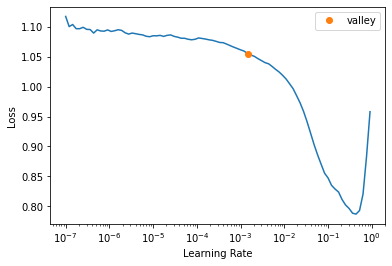

In [ ]:
learner_googlenet.lr_find()

In [ ]:
learner_googlenet.fine_tune(5, base_lr=0.001, freeze_epochs=5)

epoch,train_loss,valid_loss,f1_score,time
0,0.871169,0.667799,0.255148,01:48
1,0.388572,0.203219,0.722353,01:48
2,0.147637,0.116820,0.738109,01:48
3,0.126228,0.107565,0.758471,01:48
4,0.115420,0.103799,0.761603,01:48


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

epoch,train_loss,valid_loss,f1_score,time
0,0.106536,0.100104,0.772140,02:18
1,0.102327,0.098241,0.781622,02:15
2,0.099039,0.096220,0.782509,02:14
3,0.099212,0.095482,0.786813,02:15
4,0.098133,0.095328,0.786034,02:14


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:

### 6) vgg

In [18]:
from torchvision.models import vgg16
learner_vgg = vision_learner(dls, vgg16, loss_func= loss_function, metrics= f1_micro)

SuggestedLRs(valley=0.004365158267319202)

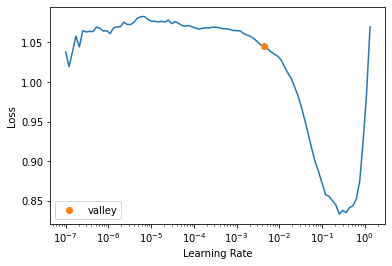

In [19]:
learner_vgg.lr_find()

In [20]:
learner_vgg.fine_tune(5, base_lr=0.004, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),time
0,0.181931,0.143397,0.667304,02:49
1,0.154844,0.130703,0.685311,02:48
2,0.147840,0.127378,0.693084,02:48
3,0.144373,0.125009,0.712411,02:48
4,0.135731,0.123454,0.701092,02:48


epoch,train_loss,valid_loss,F1(mean),time
0,0.110013,0.106570,0.754874,07:34
1,0.109443,0.102404,0.763087,07:32
2,0.102305,0.096765,0.781918,07:32
3,0.093286,0.094111,0.786881,07:32
4,0.092949,0.093659,0.791241,07:32


# model selection summary

Model Name | Loss | F1 score | 
---- | --- | --- 
resnet50 | 0.081599 | 0.826913 
resnext50_32x4d | 0.081723 | 0.831006
regnet_y_3_2gf | 0.080104	| 0.826915	
regnet_x_3_2gf | 0.082004	| 0.823918
regnetz_d8 | **0.074909**	| **0.846586**
googlenet| 0.095328 |	0.786034
vgg|0.093659|	0.791241

# Loss function selection: pos weight

## resnext50_32x4d: pos weight 1

In [ ]:
vocab_list = dls.vocab

In [ ]:
pos_weights = []

for label in vocab_list:
  positive_sample_count = train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum()
  pos_weights.append((len(train_df)-positive_sample_count)/positive_sample_count)
pos_weights

[0.3159603404404668,
 19.391570360299117,
 48.66225165562914,
 48.5801652892562,
 118.50597609561753,
 14.509824198552224,
 26.293903548680618,
 19.976223776223776,
 18.66950819672131,
 28.4078431372549,
 24.814113597246127,
 5.873510540788268,
 22.58176100628931,
 25.54513274336283,
 20.517934002869442,
 23.566748566748565,
 12.572850678733031,
 27.786948176583493]

In [ ]:
loss_function_pos_weight = nn.BCEWithLogitsLoss(pos_weight = torch.as_tensor(pos_weights, dtype=torch.float))

In [ ]:
from torchvision.models import resnext50_32x4d
learner_resnext50_32x4d_pos_weight = vision_learner(dls, resnext50_32x4d, loss_func= loss_function_pos_weight, metrics= f1_micro)

SuggestedLRs(valley=0.0006918309954926372)

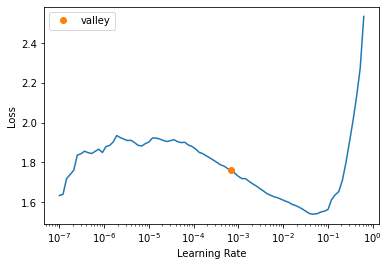

In [ ]:
learner_resnext50_32x4d_pos_weight.lr_find()

In [ ]:
learner_resnext50_32x4d_pos_weight.fine_tune(5, base_lr=0.0006, freeze_epochs=5)

epoch,train_loss,valid_loss,f1_score,time
0,1.250053,0.953826,0.244639,05:45
1,1.044719,0.818037,0.302402,05:42
2,0.788975,0.662648,0.402366,05:41
3,0.662899,0.574106,0.502805,05:41
4,0.562251,0.546926,0.542387,05:41


epoch,train_loss,valid_loss,f1_score,time
0,0.497440,0.525291,0.568139,07:21
1,0.481607,0.529306,0.570724,07:19
2,0.437811,0.518685,0.581286,07:19
3,0.401600,0.519013,0.596242,07:19
4,0.390878,0.526605,0.616716,07:19


## resnext50_32x4d pos weight 2

In [ ]:
vocab = list(dls.vocab)
pos_weights = []

for label in vocab:
  positive_sample_count = train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum()
  pos_weights.append((len(train_df)-positive_sample_count)/positive_sample_count)
pos_weights = np.array(pos_weights)
# min max scale the list
pos_weights = (pos_weights - pos_weights.min()) / (pos_weights.max() - pos_weights.min())
# add 1 to each element
pos_weights = (pos_weights*1.5) + 1
print(pos_weights)
# loss
loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.from_numpy(pos_weights))

[1.         1.24209672 1.61358344 1.61254165 2.5        1.18014039
 1.32969718 1.24951681 1.23293272 1.35652609 1.31091653 1.07053324
 1.28258479 1.32019421 1.25639188 1.29508569 1.15555743 1.34864605]


In [ ]:
from torchvision.models import resnext50_32x4d
learner_resnext50_32x4d_pos_2 = vision_learner(dls,
                                               resnext50_32x4d,
                                               loss_func= loss_function,
                                               metrics= f1_micro)

SuggestedLRs(valley=0.0020892962347716093)

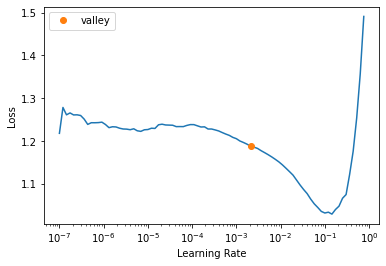

In [ ]:
learner_resnext50_32x4d_pos_2.lr_find()

In [ ]:
learner_resnext50_32x4d_pos_2.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,f1_score,time
0,0.859129,0.651021,0.319557,05:42
1,0.369427,0.292900,0.701584,05:41
2,0.292093,0.262990,0.743622,05:41
3,0.273238,0.250691,0.729851,05:41
4,0.244879,0.242217,0.756569,05:41


epoch,train_loss,valid_loss,f1_score,time
0,0.206564,0.238905,0.776069,07:19
1,0.206429,0.237237,0.780289,07:19
2,0.177329,0.237679,0.786865,07:19
3,0.160062,0.242797,0.793111,07:19
4,0.146657,0.243063,0.793340,07:19


## regnet_y_3_2gf pos_weight 1

In [ ]:
vocab_list = dls.vocab
pos_weights = []
for label in vocab_list:
  # find a list of posotive samples
  positive_sample_count = train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum()
  pos_weights.append((len(train_df)-positive_sample_count)/positive_sample_count)
pos_weights

In [ ]:
from torchvision.models import regnet_y_3_2gf
learner = vision_learner(dls, 
                         regnet_y_3_2gf, 
                         loss_func= nn.BCEWithLogitsLoss(pos_weight = torch.as_tensor(pos_weights, dtype=torch.float)), 
                         metrics= f1_samples)

SuggestedLRs(valley=0.0020892962347716093)

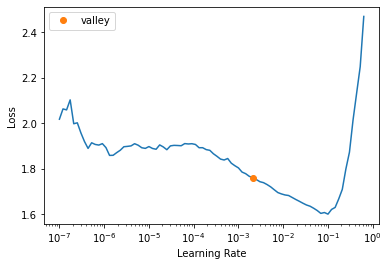

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(samples),time
0,1.132507,0.875150,0.289436,04:53
1,0.836222,0.618853,0.540192,04:52
2,0.653062,0.570464,0.591720,04:52
3,0.593861,0.533196,0.612715,04:52
4,0.575729,0.517223,0.654306,04:52


epoch,train_loss,valid_loss,F1(samples),time
0,0.469724,0.497769,0.683776,06:31
1,0.455608,0.484034,0.681651,06:35
2,0.403398,0.491998,0.710804,06:33
3,0.389516,0.492477,0.708520,06:35
4,0.361364,0.496102,0.720765,06:31


## regnet_y_3_2gf pos_weight 2

In [ ]:
vocab = list(dls.vocab)
pos_weights = []

for label in vocab:
    pos_weights.append((len(train_df)-train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum())/train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum())

pos_weights = np.array(pos_weights)
# min max scale the list
pos_weights = (pos_weights - pos_weights.min()) / (pos_weights.max() - pos_weights.min())
# add 1 to each element
pos_weights = (pos_weights*1.5) + 1
print(pos_weights)
# loss
loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.from_numpy(pos_weights))

[1.         1.24209672 1.61358344 1.61254165 2.5        1.18014039
 1.32969718 1.24951681 1.23293272 1.35652609 1.31091653 1.07053324
 1.28258479 1.32019421 1.25639188 1.29508569 1.15555743 1.34864605]


In [ ]:
# loss
loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.from_numpy(pos_weights))
from torchvision.models import regnet_y_3_2gf
learner_pos_2 = vision_learner(dls, 
                         regnet_y_3_2gf, 
                         loss_func= loss_function, 
                         metrics= f1_micro)

SuggestedLRs(valley=0.0014454397605732083)

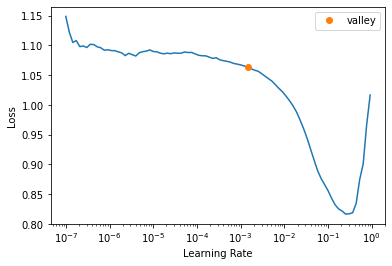

In [ ]:
learner_pos_2.lr_find()

In [ ]:
learner_pos_2.fine_tune(5, base_lr=0.001, freeze_epochs=5)

epoch,train_loss,valid_loss,f1_score,time
0,0.875357,0.677324,0.252554,04:50
1,0.405691,0.223865,0.723414,04:49
2,0.162955,0.124769,0.763059,04:49
3,0.132721,0.112706,0.784352,04:49
4,0.118896,0.106620,0.798162,04:49


epoch,train_loss,valid_loss,f1_score,time
0,0.108133,0.102170,0.804361,06:24
1,0.105460,0.099989,0.813494,06:25
2,0.098691,0.097163,0.818060,06:24
3,0.095972,0.095807,0.819709,06:24
4,0.089491,0.095314,0.822151,06:24


## regnetz_d8 pos weight 1

In [ ]:
vocab_list = dls.vocab
pos_weights = []
for label in vocab_list:
  # find a list of posotive samples
  positive_sample_count = train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum()
  pos_weights.append((len(train_df)-positive_sample_count)/positive_sample_count)
pos_weights

[0.3159603404404668,
 19.391570360299117,
 48.66225165562914,
 48.5801652892562,
 118.50597609561753,
 14.509824198552224,
 26.293903548680618,
 19.976223776223776,
 18.66950819672131,
 28.4078431372549,
 24.814113597246127,
 5.873510540788268,
 22.58176100628931,
 25.54513274336283,
 20.517934002869442,
 23.566748566748565,
 12.572850678733031,
 27.786948176583493]

In [ ]:
learner = vision_learner(dls, 
                         'regnetz_d8', 
                         loss_func= nn.BCEWithLogitsLoss(pos_weight = torch.as_tensor(pos_weights, dtype=torch.float)), 
                         metrics= [f1_micro,f1_samples])

SuggestedLRs(valley=0.0014454397605732083)

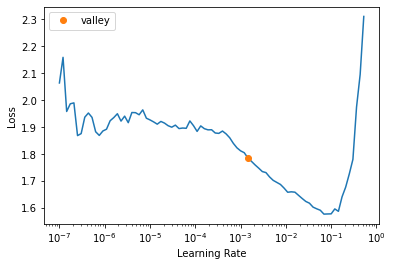

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(5, base_lr=0.001, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,1.118357,0.874538,0.270232,0.288144,09:57
1,0.864831,0.696454,0.392601,0.463709,09:50
2,0.808304,0.620932,0.475367,0.568638,09:49
3,0.640243,0.619250,0.503909,0.594023,09:49
4,0.674843,0.600258,0.494624,0.597391,09:48


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.609146,0.560821,0.536153,0.639135,14:29


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.609146,0.560821,0.536153,0.639135,14:29
1,0.545721,0.542751,0.546164,0.646428,14:28
2,0.510179,0.541939,0.553452,0.648994,14:27
3,0.453307,0.519692,0.547732,0.651203,14:26
4,0.482143,0.532474,0.584881,0.680512,14:27


## regnetz_d8 pos weight 2

In [ ]:
vocab = list(dls.vocab)
pos_weights = []

for label in vocab:
  positive_sample_count = train_df['Labels'].apply(lambda x: 1 if label in x.split(' ') else 0).sum()
  pos_weights.append((len(train_df)-positive_sample_count)/positive_sample_count)
pos_weights = np.array(pos_weights)
# min max scale the list
pos_weights = (pos_weights - pos_weights.min()) / (pos_weights.max() - pos_weights.min())
# add 1 to each element
pos_weights = pos_weights + 1
print(pos_weights)
# loss
loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.from_numpy(pos_weights))

[1.         1.16139781 1.40905563 1.4083611  2.         1.12009359
 1.21979812 1.16634454 1.15528848 1.23768406 1.20727769 1.04702216
 1.18838986 1.21346281 1.17092792 1.19672379 1.10370496 1.2324307 ]


In [ ]:
learner = vision_learner(dls,'regnetz_d8',loss_func= loss_function, metrics= [f1_micro,f1_samples])

SuggestedLRs(valley=0.0030199517495930195)

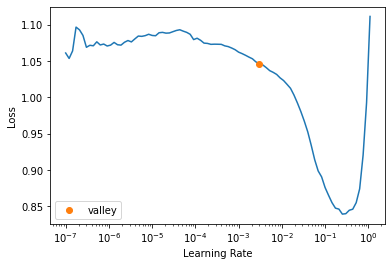

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(5, base_lr=0.003, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.209954,0.142734,0.732099,0.751878,09:49
1,0.140871,0.122920,0.748501,0.767829,09:49
2,0.134217,0.113741,0.773407,0.802096,09:48
3,0.125634,0.109455,0.780834,0.808348,09:48
4,0.110796,0.100895,0.801496,0.827922,09:48


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.100804,0.095224,0.811386,0.833235,14:28
1,0.094574,0.089045,0.825530,0.849168,14:29
2,0.081629,0.085801,0.834079,0.856789,14:29
3,0.077677,0.084252,0.839198,0.860406,14:21
4,0.075492,0.084041,0.837841,0.861771,14:21


# Pos weight summary

Model Name | Loss | F1 score | 
---- | --- | --- 
resnext50_32x4d: pos weight 1 | 0.526605 | 0.616716
resnext50_32x4d: pos weight 2 | 0.243063 |	0.793340
regnet_y_3_2gf: pos_weight 1 | 0.496102 |	0.720765	
regnet_y_3_2gf pos_weight 2 | 0.095314 |	0.822151
regnetz_d8 pos weight 1 | 0.532474|	0.584881
regnetz_d8 pos weight 2| **0.084041**|	**0.837841**

# Data augmentation

The models we test before is tranmsforms, no scale

## regnet_y_3_2gf: no transforms, no scale

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=1),  # resize the images, default is 0.08
                  #  batch_tfms=aug_transforms(pad_mode='zeros') # like stretch the images, padding, and many other data augmentations
                   )  
# preview of images
dls = images.dataloaders(train_df,bs=24)
# dls.show_batch()

Downloading: "https://download.pytorch.org/models/regnet_y_3_2gf-b5a9779c.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_3_2gf-b5a9779c.pth


  0%|          | 0.00/74.6M [00:00<?, ?B/s]

SuggestedLRs(valley=0.00363078061491251)

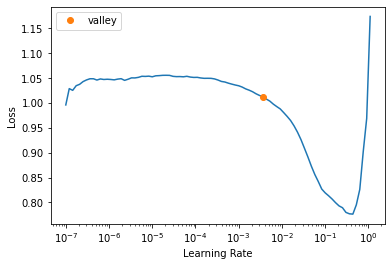

In [ ]:
# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

from torchvision.models import regnet_y_3_2gf
learner_regnet_y_3_2gf_no_transforms_no_scale = vision_learner(dls, regnet_y_3_2gf, loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_y_3_2gf_no_transforms_no_scale.lr_find()

In [ ]:
learner_regnet_y_3_2gf_no_transforms_no_scale.fine_tune(5, base_lr=0.003, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.619394,0.384578,0.543985,0.603350,04:43
1,0.140786,0.111689,0.750015,0.768782,04:42
2,0.111397,0.097073,0.784220,0.808200,04:41
3,0.097167,0.090482,0.801905,0.827000,04:40
4,0.089574,0.086289,0.813530,0.840712,04:41


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.071546,0.083925,0.817646,0.842904,06:15
1,0.071456,0.085086,0.820434,0.844258,06:14
2,0.058843,0.085980,0.822174,0.847527,06:14
3,0.048188,0.088378,0.823523,0.848357,06:14
4,0.041930,0.088820,0.824695,0.849502,06:14


## regnetz_d8: no transforms, no scale

SuggestedLRs(valley=0.002511886414140463)

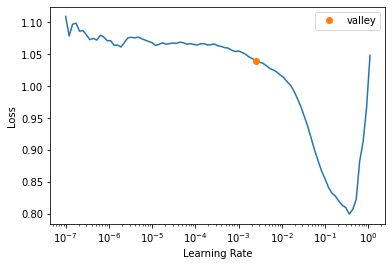

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
learner_regnetz_d8_no_transforms_no_scale = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnetz_d8_no_transforms_no_scale.lr_find()

In [ ]:
learner_regnetz_d8_no_transforms_no_scale.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.347640,0.199469,0.723025,0.747737,09:28
1,0.133166,0.117503,0.737512,0.760757,09:27
2,0.117965,0.108635,0.755051,0.779437,09:27
3,0.110879,0.099690,0.779306,0.805734,09:26
4,0.096650,0.094619,0.792059,0.817703,09:26


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.089183,0.089552,0.806944,0.832596,14:01
1,0.084597,0.086452,0.809739,0.832150,14:06
2,0.071841,0.085149,0.821044,0.848080,14:02
3,0.065124,0.085754,0.823356,0.846837,14:01
4,0.061234,0.086235,0.822827,0.847913,14:01


## regnet_y_3_2gf: scale, no transforms

SuggestedLRs(valley=0.0008317637839354575)

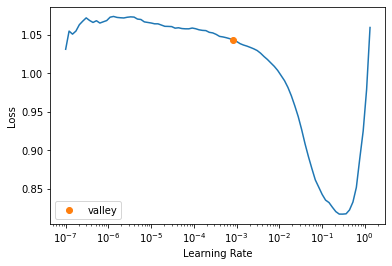

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=0.08),  # resize the images, default is 0.08
                  #  batch_tfms=aug_transforms(pad_mode='zeros') # like stretch the images, padding, and many other data augmentations
                   )  
# dataloader
dls = images.dataloaders(train_df)

# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

from torchvision.models import regnet_y_3_2gf
learner_regnet_y_3_2gf_scale_no_transforms = vision_learner(dls, regnet_y_3_2gf, loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_y_3_2gf_scale_no_transforms.lr_find()

In [ ]:
learner_regnet_y_3_2gf_scale_no_transforms.fine_tune(5, base_lr=0.0008, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.899232,0.686609,0.234000,0.232382,04:40
1,0.522373,0.317613,0.635130,0.668106,04:40
2,0.182344,0.125141,0.708580,0.727167,04:40
3,0.153148,0.111253,0.739814,0.758909,04:40
4,0.139782,0.103532,0.767195,0.790339,04:40


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.126307,0.099193,0.773843,0.796049,06:15
1,0.127006,0.096011,0.783833,0.808420,06:14
2,0.122637,0.093897,0.790140,0.814559,06:14
3,0.115458,0.092151,0.794396,0.817840,06:14
4,0.116771,0.091886,0.794049,0.818384,06:15


## regnetz_d8: scale, no transforms

SuggestedLRs(valley=0.0010000000474974513)

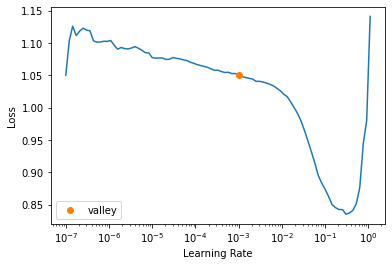

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=0.08),  # resize the images, default is 0.08
                  #  batch_tfms=aug_transforms(pad_mode='zeros') # like stretch the images, padding, and many other data augmentations
                   )  
# dataloader
dls = images.dataloaders(train_df,bs=24)

# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

learner_regnet_d8_scale_no_transforms = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_d8_scale_no_transforms.lr_find()

In [ ]:
learner_regnet_d8_scale_no_transforms.fine_tune(5, base_lr=0.001, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.701975,0.494999,0.367145,0.393732,09:28
1,0.180178,0.126561,0.709413,0.729472,09:27
2,0.151151,0.118328,0.731856,0.753774,09:26
3,0.141381,0.110598,0.751455,0.778292,09:27
4,0.131180,0.106575,0.749451,0.772672,09:26


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.126212,0.098976,0.769872,0.796345,14:04
1,0.122743,0.094492,0.786313,0.813663,14:03
2,0.118009,0.091099,0.794906,0.823244,14:03
3,0.109446,0.089286,0.800287,0.826786,14:03
4,0.109614,0.089851,0.796426,0.822423,14:03


## regnet_y_3_2gf: scale and transforms

Downloading: "https://download.pytorch.org/models/regnet_y_3_2gf-b5a9779c.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_3_2gf-b5a9779c.pth


  0%|          | 0.00/74.6M [00:00<?, ?B/s]

SuggestedLRs(valley=0.002511886414140463)

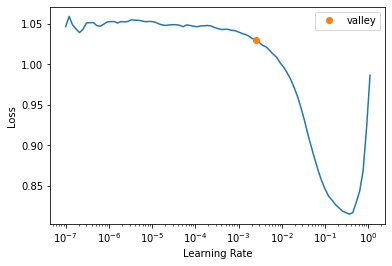

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=0.08),  # resize the images, default is 0.08
                   batch_tfms=aug_transforms(pad_mode='zeros')  # like stretch the images, padding, and many other data augmentations
                   )  
# dataloader
dls = images.dataloaders(train_df)

# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

from torchvision.models import regnet_y_3_2gf
learner_regnet_y_3_2gf_scale_and_transforms = vision_learner(dls, regnet_y_3_2gf, loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_y_3_2gf_scale_and_transforms.lr_find()

In [ ]:
learner_regnet_y_3_2gf_scale_and_transforms.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.773674,0.540174,0.335759,0.352627,04:53
1,0.208355,0.132637,0.679791,0.681463,04:52
2,0.158376,0.115509,0.722358,0.741124,04:51
3,0.139909,0.103750,0.764455,0.783938,04:51
4,0.129432,0.098450,0.772160,0.793498,04:51


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.123278,0.092506,0.792066,0.818929,06:32
1,0.119055,0.090373,0.794592,0.817810,06:31
2,0.117426,0.087796,0.807952,0.832792,06:31
3,0.116082,0.086132,0.810782,0.836443,06:31
4,0.108007,0.086253,0.810849,0.834548,06:31


## regnetz_d8: scale and transforms

SuggestedLRs(valley=0.00363078061491251)

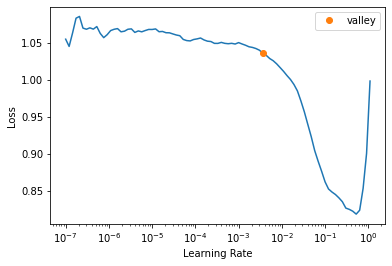

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=0.08),  # resize the images, default is 0.08
                   batch_tfms=aug_transforms(pad_mode='zeros')  # like stretch the images, padding, and many other data augmentations
                   )  
# dataloader
dls = images.dataloaders(train_df, bs=24)

# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

learner_regnet_d8_scale_and_transforms = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_d8_scale_and_transforms.lr_find()

In [ ]:
learner_regnet_d8_scale_and_transforms.fine_tune(5, base_lr=0.003, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.225800,0.142796,0.694158,0.714993,09:50
1,0.163251,0.117827,0.733161,0.758904,09:47
2,0.150109,0.111430,0.745350,0.764966,09:46
3,0.144006,0.103706,0.759038,0.783490,09:46
4,0.130809,0.097667,0.779102,0.803923,09:46


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.119437,0.093055,0.788592,0.813575,14:25
1,0.113758,0.087283,0.803024,0.832670,14:24
2,0.108799,0.082685,0.816781,0.843814,14:24
3,0.108932,0.080689,0.822692,0.849621,14:24
4,0.104357,0.079881,0.825040,0.851992,14:23


## regnet_y_3_2gf: no scale, transforms, and erasing

SuggestedLRs(valley=0.0020892962347716093)

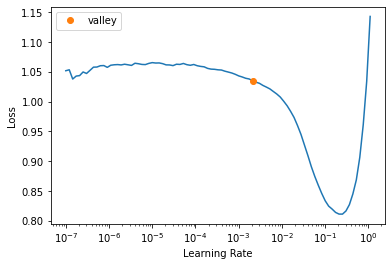

In [ ]:
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),
                   get_y=ColReader('Labels', label_delim=' '),
                   splitter=RandomSplitter(seed=5206),
                   item_tfms=RandomResizedCrop(320, min_scale=1),
                   batch_tfms=[*aug_transforms(pad_mode='zeros', xtra_tfms=RandomErasing())])

# dataloader
dls = images.dataloaders(train_df)

# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

from torchvision.models import regnet_y_3_2gf
learner_regnet_y_3_2gf_no_scale_transforms_erasing = vision_learner(dls, regnet_y_3_2gf, loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_y_3_2gf_no_scale_transforms_erasing.lr_find()

In [ ]:
learner_regnet_y_3_2gf_scale_no_transforms.fine_tune(5, base_lr=0.002, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.116663,0.091566,0.795834,0.820511,04:47
1,0.122145,0.092045,0.794644,0.818752,04:46
2,0.119536,0.092687,0.794542,0.820002,04:46
3,0.115104,0.090122,0.801703,0.829035,04:46
4,0.114225,0.087629,0.809326,0.836832,04:46


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.107439,0.085028,0.812696,0.837364,06:14
1,0.105521,0.084588,0.811723,0.838042,06:14
2,0.107240,0.082564,0.819834,0.844585,06:14
3,0.101094,0.081686,0.821578,0.846785,06:14
4,0.100706,0.081486,0.821441,0.847377,06:14


## regnetz_d8: no scale, transforms, and erasing

SuggestedLRs(valley=0.0030199517495930195)

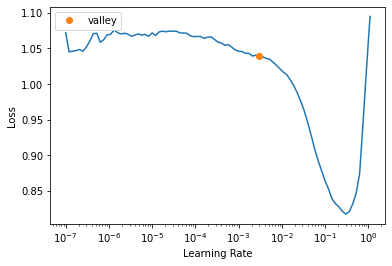

In [ ]:
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),
                   get_y=ColReader('Labels', label_delim=' '),
                   splitter=RandomSplitter(seed=5206),
                   item_tfms=RandomResizedCrop(320, min_scale=1),
                   batch_tfms=[*aug_transforms(pad_mode='zeros', xtra_tfms=RandomErasing())])

# dataloader
dls = images.dataloaders(train_df,bs=24)

# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()


learner_regnet_d8_no_scale_transforms_erasing = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])

learner_regnet_d8_no_scale_transforms_erasing.lr_find()

In [ ]:
learner_regnet_d8_no_scale_transforms_erasing.fine_tune(5, base_lr=0.003, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.203375,0.132749,0.726790,0.749397,09:44
1,0.132191,0.110782,0.754032,0.779215,09:43
2,0.127017,0.102450,0.771579,0.797742,09:42
3,0.110032,0.095840,0.786213,0.813666,09:42
4,0.111630,0.093687,0.792467,0.819824,09:42


epoch,train_loss,valid_loss,F1(mean),F1(samples),time


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.093284,0.084875,0.813082,0.837835,14:22
1,0.091746,0.080281,0.823843,0.849047,14:21
2,0.084043,0.075862,0.834475,0.857262,14:21
3,0.079237,0.075369,0.838698,0.863245,14:21
4,0.077097,0.074348,0.844845,0.869409,14:21


# Data augmentation summary

Model Name | Loss | F1 score | 
---- | --- | --- 
regnet_y_3_2gf: No augmentations | 0.088820 |	0.824695
regnetz_d8: No augmentations| 0.086235 |	0.822827
regnet_y_3_2gf: scale | 0.091886 |	0.794049	
regnetz_d8: scale| 0.089851	| 0.796426
regnet_y_3_2gf: transforms | 0.080104 |	0.826915
regnetz_d8: transforms| 0.074909|	**0.846586**
regnet_y_3_2gf: scale, transforms| 0.086253	|0.810849
regnetz_d8: scale, transforms| 0.079881	| 0.825040
regnet_y_3_2gf: transforms, erasing| 0.081486	| 0.821441
regnetz_d8: transforms, erasing |**0.074348**	|0.844845

# Resolution

### 224

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(224, min_scale=1),  # resize the images, there we can also do other images transforms
                   batch_tfms=aug_transforms(pad_mode='zeros'))  # like stretch the images, padding, and many other data augmentations
# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

# preview of images
dls = images.dataloaders(train_df,bs=24) # batch size is 24
learner_regnetz_d8_224 = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])

SuggestedLRs(valley=0.005248074419796467)

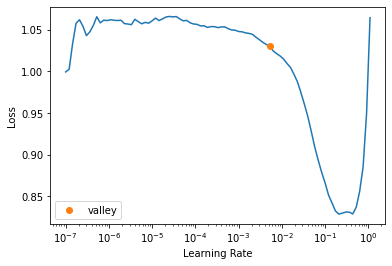

In [ ]:
learner_regnetz_d8_224.lr_find()

In [ ]:
learner_regnetz_d8_224.fine_tune(5, base_lr=0.005, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.172344,0.136076,0.689651,0.711891,05:38
1,0.133564,0.117651,0.730176,0.749745,05:37
2,0.125156,0.108997,0.749042,0.768190,05:37
3,0.117637,0.102563,0.762541,0.785281,05:37
4,0.104014,0.096516,0.778414,0.802378,05:37


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.094806,0.086521,0.809854,0.834726,08:46
1,0.086728,0.082490,0.820384,0.845180,08:41
2,0.079027,0.079681,0.827611,0.850892,08:42
3,0.075146,0.078016,0.833206,0.857899,08:41
4,0.068041,0.078387,0.833480,0.857660,08:43


### 256

SuggestedLRs(valley=0.0030199517495930195)

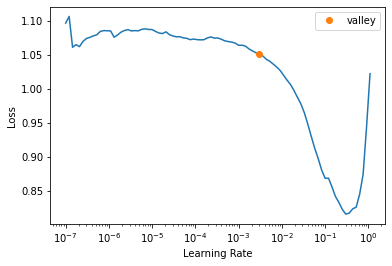

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(256, min_scale=1),  # resize the images, there we can also do other images transforms
                   batch_tfms=aug_transforms(pad_mode='zeros'))  # like stretch the images, padding, and many other data augmentations
# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

# preview of images
dls = images.dataloaders(train_df,bs=24) # batch size is 24
learner_regnetz_d8_256 = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])
learner_regnetz_d8_256.lr_find()

In [ ]:
learner_regnetz_d8_256.fine_tune(5, base_lr=0.003, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.204715,0.138324,0.702654,0.716414,07:02
1,0.129159,0.119955,0.725117,0.746184,07:00
2,0.126199,0.108030,0.758659,0.782570,07:01
3,0.111409,0.102460,0.765486,0.790625,07:00
4,0.106172,0.094983,0.786780,0.814617,07:00


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.096647,0.089841,0.797123,0.825091,10:21
1,0.091116,0.083359,0.816670,0.844728,10:20
2,0.086057,0.081181,0.824587,0.849719,10:20
3,0.074425,0.079480,0.828241,0.853364,10:20
4,0.072677,0.079558,0.826899,0.851688,10:20


### 360

SuggestedLRs(valley=0.004365158267319202)

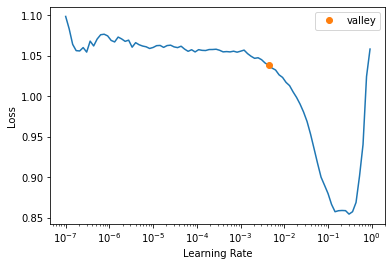

In [ ]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(seed=5206),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(360, min_scale=1),  # resize the images, there we can also do other images transforms
                   batch_tfms=aug_transforms(pad_mode='zeros'))  # like stretch the images, padding, and many other data augmentations
# define a loss function, since this is a multi-label task, we will use BCEWithLogitsLoss
loss_function = nn.BCEWithLogitsLoss()

# preview of images
dls = images.dataloaders(train_df,bs=16) # batch size is 24
learner_regnetz_d8_360 = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])
learner_regnetz_d8_360.lr_find()

In [ ]:
learner_regnetz_d8_360.fine_tune(5, base_lr=0.004, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.165684,0.125518,0.718204,0.742461,12:47
1,0.126759,0.112095,0.746267,0.770502,12:47
2,0.119930,0.103906,0.764874,0.784136,12:47
3,0.108938,0.092747,0.792102,0.809532,12:46
4,0.097943,0.089953,0.803706,0.828332,12:46


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.087014,0.082537,0.819975,0.843298,19:11
1,0.083000,0.079340,0.827545,0.853165,19:09
2,0.079266,0.075661,0.838638,0.862025,19:09
3,0.074519,0.075528,0.839993,0.863976,19:09
4,0.068961,0.074329,0.843807,0.867509,19:09


# Resolution summary

Model Name | Loss | F1 score | 
---- | --- | --- 
regnetz_d8: 224P| 0.078387	| 0.833480
regnetz_d8: 256P| 0.079558	| 0.826899
regnetz_d8: 320P | 0.074909	| **0.846586**	
regnetz_d8: 360P | **0.074329**	| 0.843807


# Final model submitted to Kaggle

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/regnetz_d8_bh-afc03c55.pth" to /root/.cache/torch/hub/checkpoints/regnetz_d8_bh-afc03c55.pth


SuggestedLRs(valley=0.004365158267319202)

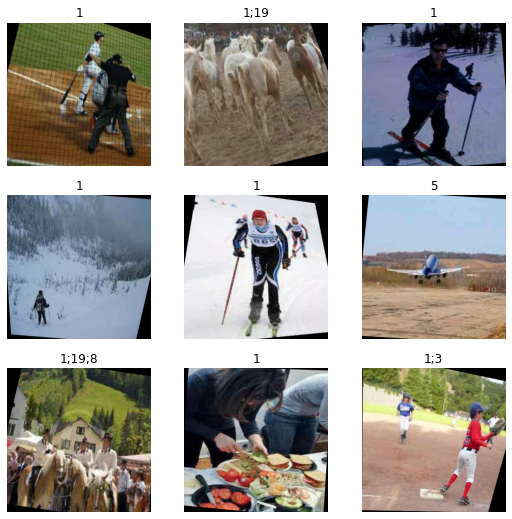

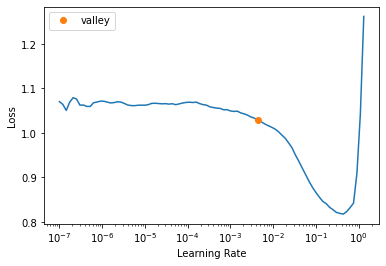

In [13]:
# load the images data
images = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  # multi-label task
                   get_x=ColReader('ImageID', pref=str('/content/COMP5329S1A2Dataset/train/')),  # X, features: dirctory of images
                   get_y=ColReader('Labels', label_delim=' '),  # y, labels: labels seperated by ' ', as this is a multi-label task, we need to seperate the labels first.
                   splitter=RandomSplitter(valid_pct = 0.05, seed=42),  # create validation set, uniformely stratify according to the labels distribution
                   item_tfms=RandomResizedCrop(320, min_scale=1),  # resize the images, there we can also do other images transforms
                   batch_tfms=aug_transforms(pad_mode='zeros'))  # like stretch the images, padding, and many other data augmentations

loss_function = nn.BCEWithLogitsLoss()

# preview of images
dls = images.dataloaders(train_df,bs=24) # batch size is 24
dls.show_batch()
learner_regnetz_d8 = vision_learner(dls, 'regnetz_d8', loss_func= loss_function, metrics= [f1_micro,f1_samples])
learner_regnetz_d8.lr_find()

In [14]:
learner_regnetz_d8.fine_tune(5, base_lr=0.004, freeze_epochs=5)

epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.150722,0.116763,0.747592,0.767857,10:38
1,0.123408,0.106055,0.763529,0.785410,10:36
2,0.119378,0.097293,0.788117,0.813491,10:36
3,0.102949,0.093251,0.796082,0.817232,10:36
4,0.098911,0.082480,0.818769,0.847231,10:36


epoch,train_loss,valid_loss,F1(mean),F1(samples),time
0,0.082724,0.076899,0.831584,0.859626,15:48
1,0.082144,0.072755,0.843322,0.871610,15:47
2,0.072706,0.070580,0.850873,0.876904,15:47
3,0.067297,0.069698,0.853572,0.877708,15:46
4,0.065439,0.070802,0.853352,0.878166,15:47


In [23]:
# save the model
torch.save(learner_regnetz_d8.model, "/content/drive/MyDrive/5329/learner_regnetz_d8.pt")

# thresold of the sigmoid activation - multilabel classification
threshold = 0.5

# vocab is the name of labels
vocab = dls.vocab

# define a dataframe to save the results
result = pd.DataFrame()

# load the test images
test_file = get_image_files(test_image_path)
test_dataloader = learner_regnetz_d8.dls.test_dl(test_file)

# predict the images classcification
predicted, _ = learner_regnetz_d8.get_preds(dl=test_dataloader)

# store the predicted labels into a list
predicted_labels = ["" for i in range(len(test_file))]

# if the activate result is greater than 0.5, then keep it, otherwise drop it
for row, vector in torch.nonzero(predicted > threshold):
    predicted_labels[row] += vocab[int(vector.item())]
    predicted_labels[row] += ' '

# store the result in the data frame, concate the ID and labels
result["ImageID"] = [os.path.basename(test_image) for test_image in test_file]
result["Labels"] = predicted_labels

result.to_csv('/content/drive/MyDrive/5329/learner_regnetz_d8.txt', header=["ImageID", "Labels"], index=False)

result = pd.read_csv('/content/drive/MyDrive/5329/learner_regnetz_d8.txt')

# We find there are quite a few empty labels
# Based on the statistics, we found most of the images are class 1,
# So we manually assign the label 1 to those empty labels.
result['Labels'].fillna(1, inplace=True)
result.to_csv('/content/drive/MyDrive/5329/learner_regnetz_d8.txt', header=["ImageID", "Labels"], index=False)
# incase you need the csv file
result.to_csv('/content/drive/MyDrive/5329/learner_regnetz_d8.csv', header=["ImageID", "Labels"], index=False)